In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [6]:
X_train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col = 'id')
y_train = X_train['Rings']
X_test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col = 'id')

In [6]:
X_train

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
id                                                                  
0       F   0.550     0.430   0.150        0.7715          0.3285   
1       F   0.630     0.490   0.145        1.1300          0.4580   
2       I   0.160     0.110   0.025        0.0210          0.0055   
3       M   0.595     0.475   0.150        0.9145          0.3755   
4       I   0.555     0.425   0.130        0.7820          0.3695   
...    ..     ...       ...     ...           ...             ...   
90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614   I   0.425     0.325   0.100        0.3455          0.1525   

       Whole weight.2  Shell weight  Rings  
id                                          
0              0.1465        0.2400     11  
1              0.2765        0.3200     11  
2              0.0030        0.0050      6  
3              0.2055        0.2500     10  
4              0.1600        0.1975      9  
...               ...           ...    ...  
90610          0.0370        0.0450      6  
90611          0.1815        0.2400      9  
90612          0.0785        0.0815      6  
90613          0.0490        0.0700      6  
90614          0.0785        0.1050      8  

[90615 rows x 9 columns]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [8]:
'''X_train.isna().sum()'''

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

No missing values

In [8]:
if 'F' not in X_train.columns:
    X_train = pd.concat([X_train,pd.get_dummies(X_train['Sex']).astype('float')], axis = 1)
    X_test = pd.concat([X_test,pd.get_dummies(X_test['Sex']).astype('float')], axis = 1)
X_train

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
id                                                                  
0       F   0.550     0.430   0.150        0.7715          0.3285   
1       F   0.630     0.490   0.145        1.1300          0.4580   
2       I   0.160     0.110   0.025        0.0210          0.0055   
3       M   0.595     0.475   0.150        0.9145          0.3755   
4       I   0.555     0.425   0.130        0.7820          0.3695   
...    ..     ...       ...     ...           ...             ...   
90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614   I   0.425     0.325   0.100        0.3455          0.1525   

       Whole weight.2  Shell weight  Rings    F    I    M  
id                                                         
0              0.1465        0.2400     11  1.0  0.0  0.0  
1              0.2765        0.3200     11  1.0  0.0  0.0  
2              0.0030        0.0050      6  0.0  1.0  0.0  
3              0.2055        0.2500     10  0.0  0.0  1.0  
4              0.1600        0.1975      9  0.0  1.0  0.0  
...               ...           ...    ...  ...  ...  ...  
90610          0.0370        0.0450      6  0.0  0.0  1.0  
90611          0.1815        0.2400      9  0.0  0.0  1.0  
90612          0.0785        0.0815      6  0.0  1.0  0.0  
90613          0.0490        0.0700      6  0.0  1.0  0.0  
90614          0.0785        0.1050      8  0.0  1.0  0.0  

[90615 rows x 12 columns]

In [7]:
weight_diff = X_train['Whole weight'] - X_train['Whole weight.1'] - X_train['Whole weight.1'] - X_train['Shell weight']
weight_diff.describe()

count    90615.000000
mean        -0.118419
std          0.110726
min         -1.594000
25%         -0.177500
50%         -0.098000
75%         -0.040000
max          0.718500
dtype: float64

In [87]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_log_error

def evaluate_dataset(data, target):
    model = XGBRegressor(n_estimators = 100)
    data = data.select_dtypes(include = ['float64', 'int64'])
    if 'Rings' in data.columns:
        data = data.drop(columns = 'Rings')
    
    kf = RepeatedKFold(n_splits = 5, n_repeats = 3,random_state=0)
    
    scores = []
    
    for train_index, test_index in kf.split(data):
        model.fit(data.iloc[train_index], target.iloc[train_index])
        preds = model.predict(data.iloc[test_index])
        preds = np.round(preds,0)
        scores.append(np.sqrt(mean_squared_log_error(preds,target.iloc[test_index])))
        
    return sum(scores)/len(scores)

def evaluate_outliers(data, target, new_data, new_target):
    model = XGBRegressor(n_estimators = 100)
    data = data.select_dtypes(include = ['float64', 'int64'])
    data = data.drop(columns = 'Rings')
    new_data = new_data.select_dtypes(include = ['float64', 'int64'])
    new_data = new_data.drop(columns = 'Rings')
    
    kf = RepeatedKFold(n_splits = 5, n_repeats = 3,random_state=0)
    
    scores = []
    
    for train_index, test_index in kf.split(data):
        d = data.iloc[train_index]
        idx = d.index.intersection(new_data.index)
        model.fit(d.loc[idx], target.loc[idx])
        preds = model.predict(data.iloc[test_index])
        preds = np.round(preds,0)
        scores.append(np.sqrt(mean_squared_log_error(preds,target.iloc[test_index])))
        
    return sum(scores)/len(scores)

In [136]:
evaluate_dataset(X_train, y_train)

0.15407457630853832

In [20]:
X_train.select_dtypes(include=['float64','int64']).skew()

Length           -0.732015
Diameter         -0.695236
Height            0.309975
Whole weight      0.429316
Whole weight.1    0.591973
Whole weight.2    0.476733
Shell weight      0.479092
Rings             1.204273
F                 0.912862
I                 0.559922
M                 0.664250
dtype: float64

In [41]:
from sklearn.ensemble import IsolationForest

contaminations = np.arange(0.0001,0.001,0.0001)

for contamination in contaminations:
    isolf = IsolationForest(random_state=0, contamination = contamination)
    outliers = isolf.fit_predict(X_train.select_dtypes(include=['float64','int64']))
    score = evaluate_outliers(X_train, y_train, X_train[outliers == 1],y_train[outliers == 1])
    print(contamination, score)

0.0001 0.15403478580173108
0.0002 0.1539263196516105
0.00030000000000000003 0.1540567449603484
0.0004 0.15398151525673268
0.0005 0.1540154521980571
0.0006000000000000001 0.15400952540359322
0.0007000000000000001 0.15399426873913394
0.0008 0.1540870794961808
0.0009000000000000001 0.15411612244763556


In [49]:
isolf = IsolationForest(random_state=0, contamination = 0.0002)
outliers = isolf.fit_predict(X_train.select_dtypes(include=['float64','int64']))
X_train['outliers'] = outliers

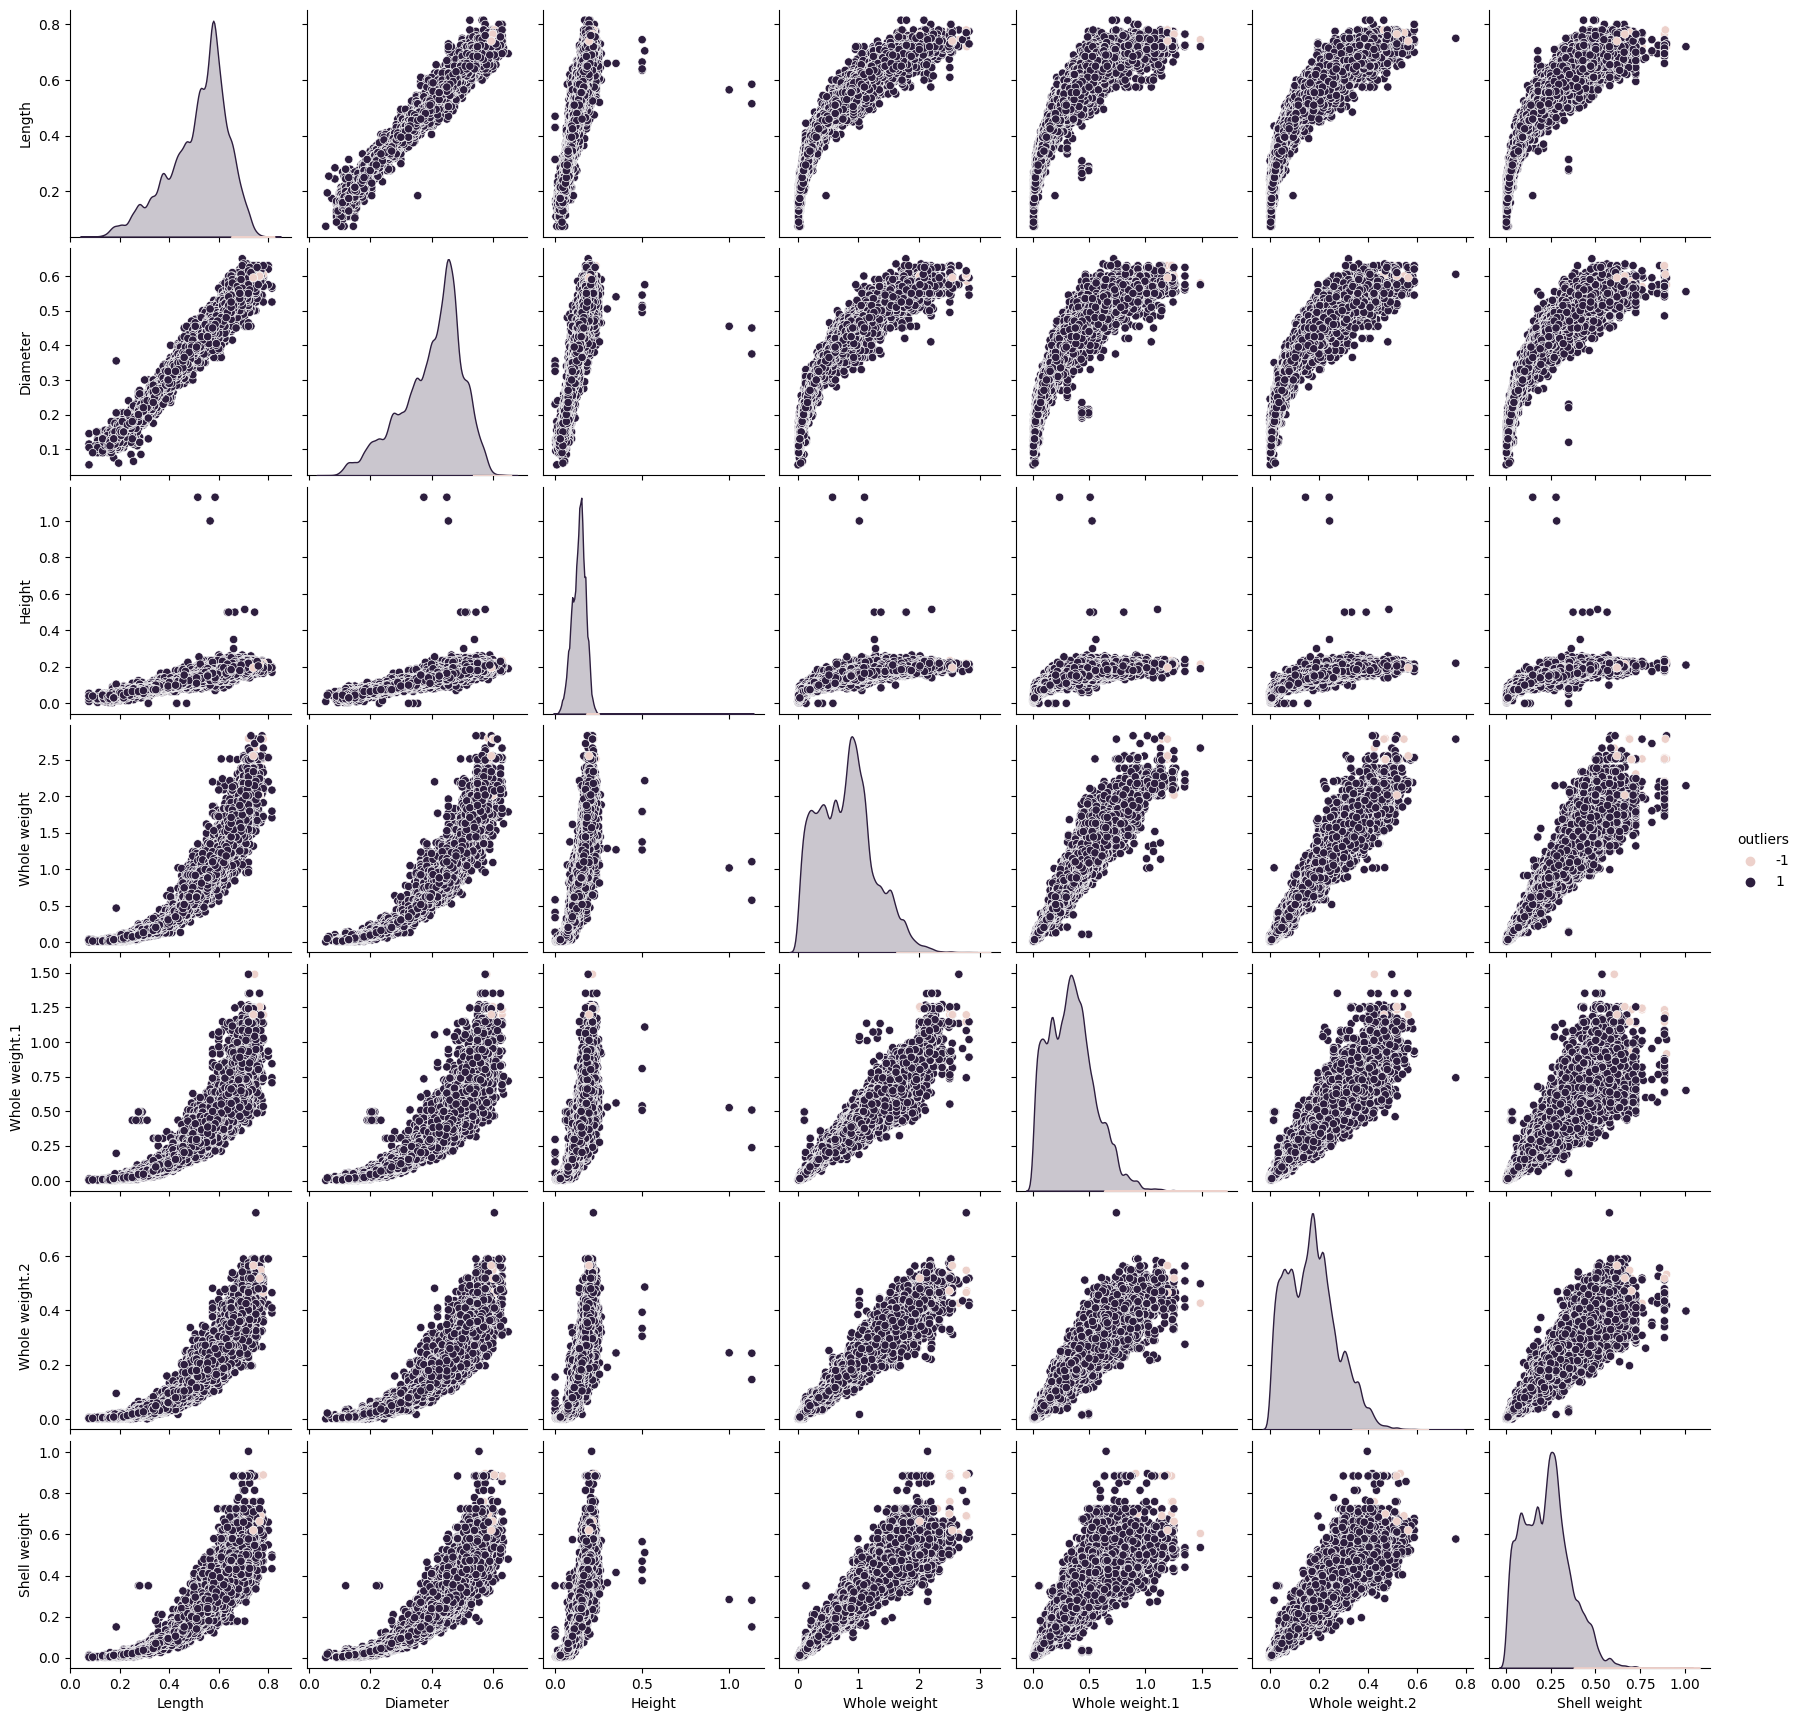

In [50]:
cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'outliers']
sns.pairplot(data = X_train.loc[:,cols], hue = 'outliers')

In [16]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

isolf2 = EllipticEnvelope(contamination = 0.001)
data = X_train.select_dtypes(include=['float64', 'int64'])
outliers = isolf2.fit_predict(data)
'''isolf2 = LocalOutlierFactor(contamination = 'auto')
data = X_train[['Diameter', 'Height']]
isolf2.fit(data)
outliers = isolf2.negative_outlier_factor_'''
data['outliers'] = outliers

<Axes: xlabel='Diameter', ylabel='Height'>

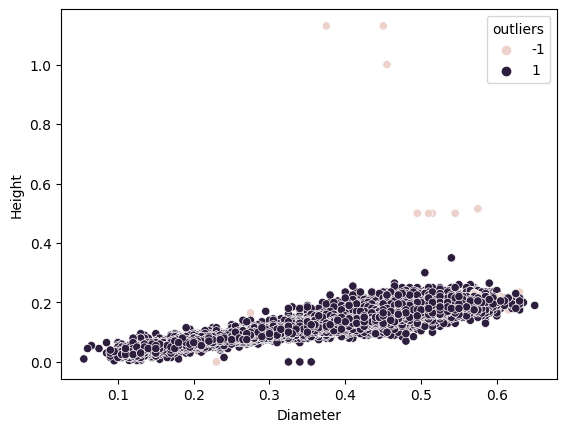

In [17]:
sns.scatterplot(data, x='Diameter', y='Height', hue = 'outliers')

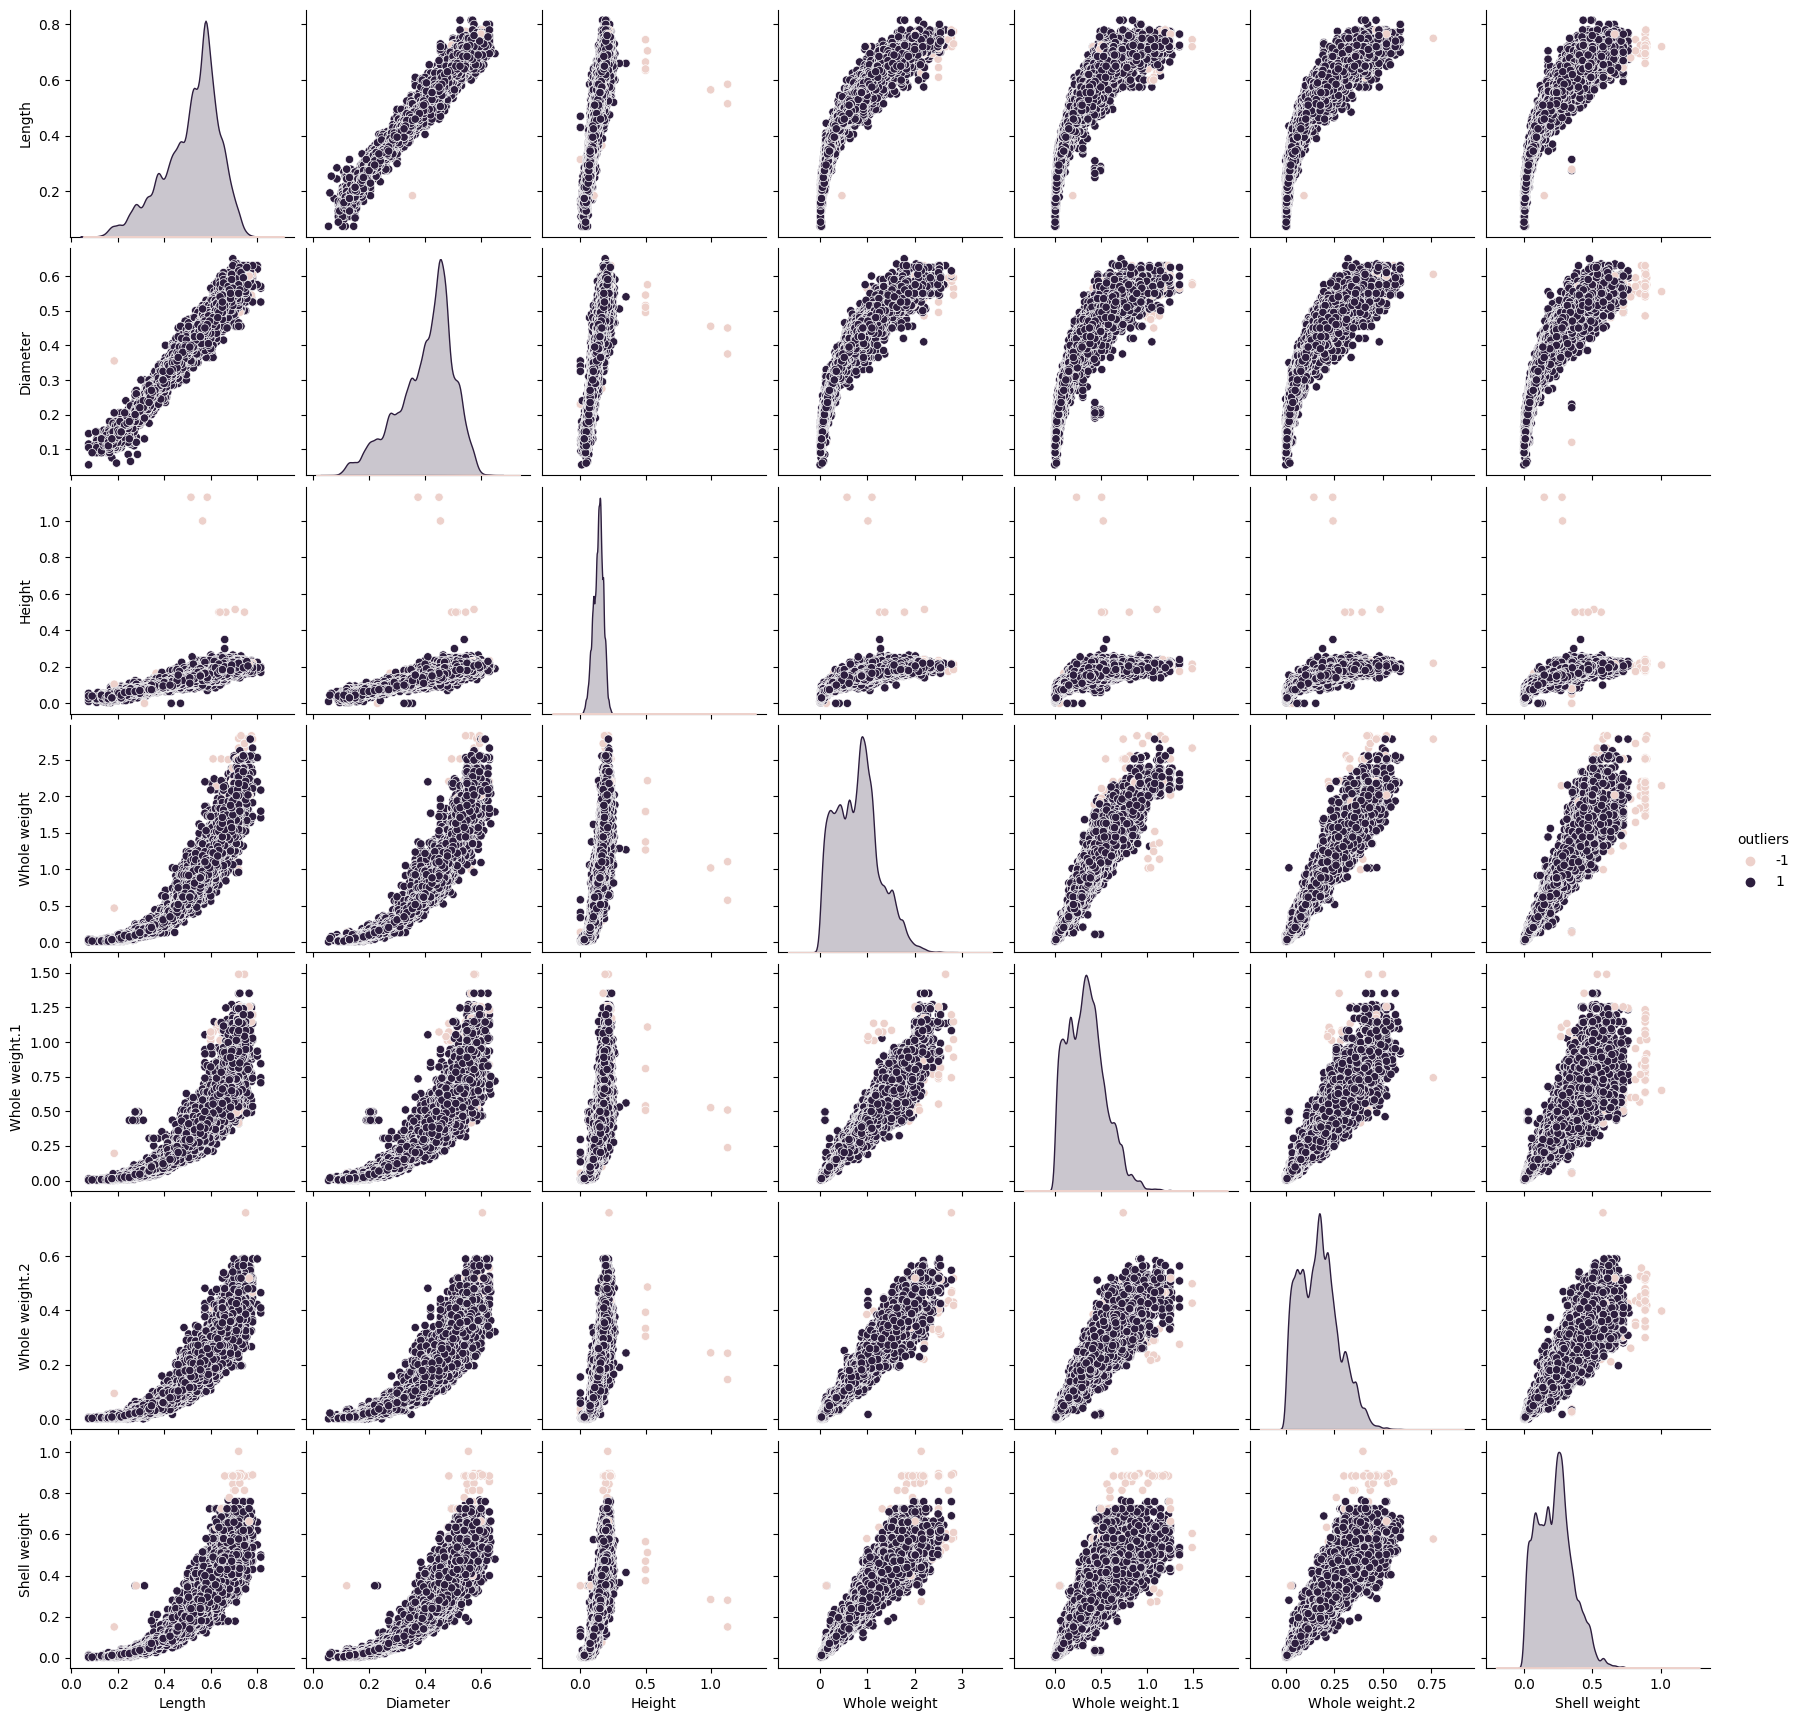

In [19]:
cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'outliers']
sns.pairplot(data = data.loc[:,cols], hue = 'outliers')

In [20]:
evaluate_outliers(X_train, y_train, X_train[outliers == 1],y_train[outliers == 1])

0.15402354875352123

In [21]:
contaminations = np.arange(0.0001,0.001,0.0001)

for contamination in contaminations:
    isolf = EllipticEnvelope(random_state=0, contamination = contamination)
    outliers = isolf.fit_predict(X_train.select_dtypes(include=['float64','int64']))
    score = evaluate_outliers(X_train, y_train, X_train[outliers == 1],y_train[outliers == 1])
    print(contamination, score)

0.0001 0.15395621039791926
0.0002 0.15408319479355864
0.00030000000000000003 0.15409284186425928
0.0004 0.15404072061404434
0.0005 0.15407976073272914
0.0006000000000000001 0.15403574262824507
0.0007000000000000001 0.15399237570792493
0.0008 0.15404835622199212
0.0009000000000000001 0.15408915397003106


In [24]:
isolf2 = EllipticEnvelope(contamination = 0.0001)
data = X_train.select_dtypes(include=['float64', 'int64'])
outliers = isolf2.fit_predict(data)
data['outliers'] = outliers

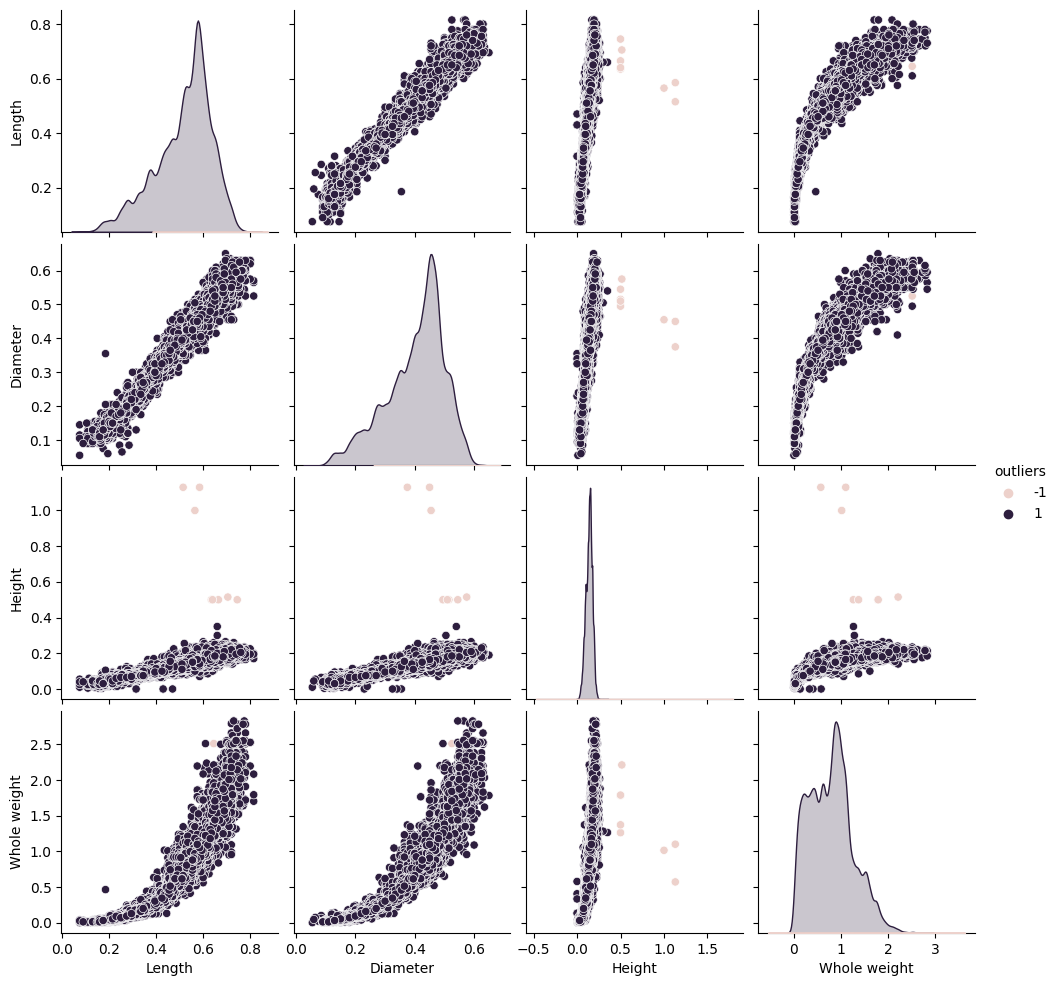

In [26]:
cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'outliers']
sns.pairplot(data = data.loc[:,cols], hue = 'outliers')

Let's manually set outliers

In [9]:
outliers = []
outliers.extend(X_train[(X_train['Length'] < 0.2) & (X_train['Diameter'] > 0.3)].index)
outliers.extend(X_train[X_train['Height'] > 0.34].index)
outliers.extend(X_train[(X_train['Length'] < 0.2) & (X_train['Whole weight'] > 0.45)].index)
outliers.extend(X_train[(X_train['Diameter'] < 0.4) & (X_train['Whole weight'] > 2)].index)
outliers.extend(X_train[X_train['Whole weight.2'] > 0.65].index)
outliers.extend(X_train[X_train['Shell weight'] > 1].index)
outliers.extend(X_train[X_train['Height'] == 0].index)
outliers.extend(X_train[X_train['Length'] == 0].index)
outliers.extend(X_train[X_train['Diameter'] == 0].index)
outliers.extend(X_train[X_train['Whole weight'] == 0].index)
outliers = list(set(outliers))

data = X_train.drop(outliers)
target = y_train.drop(outliers)
len(data)

90597

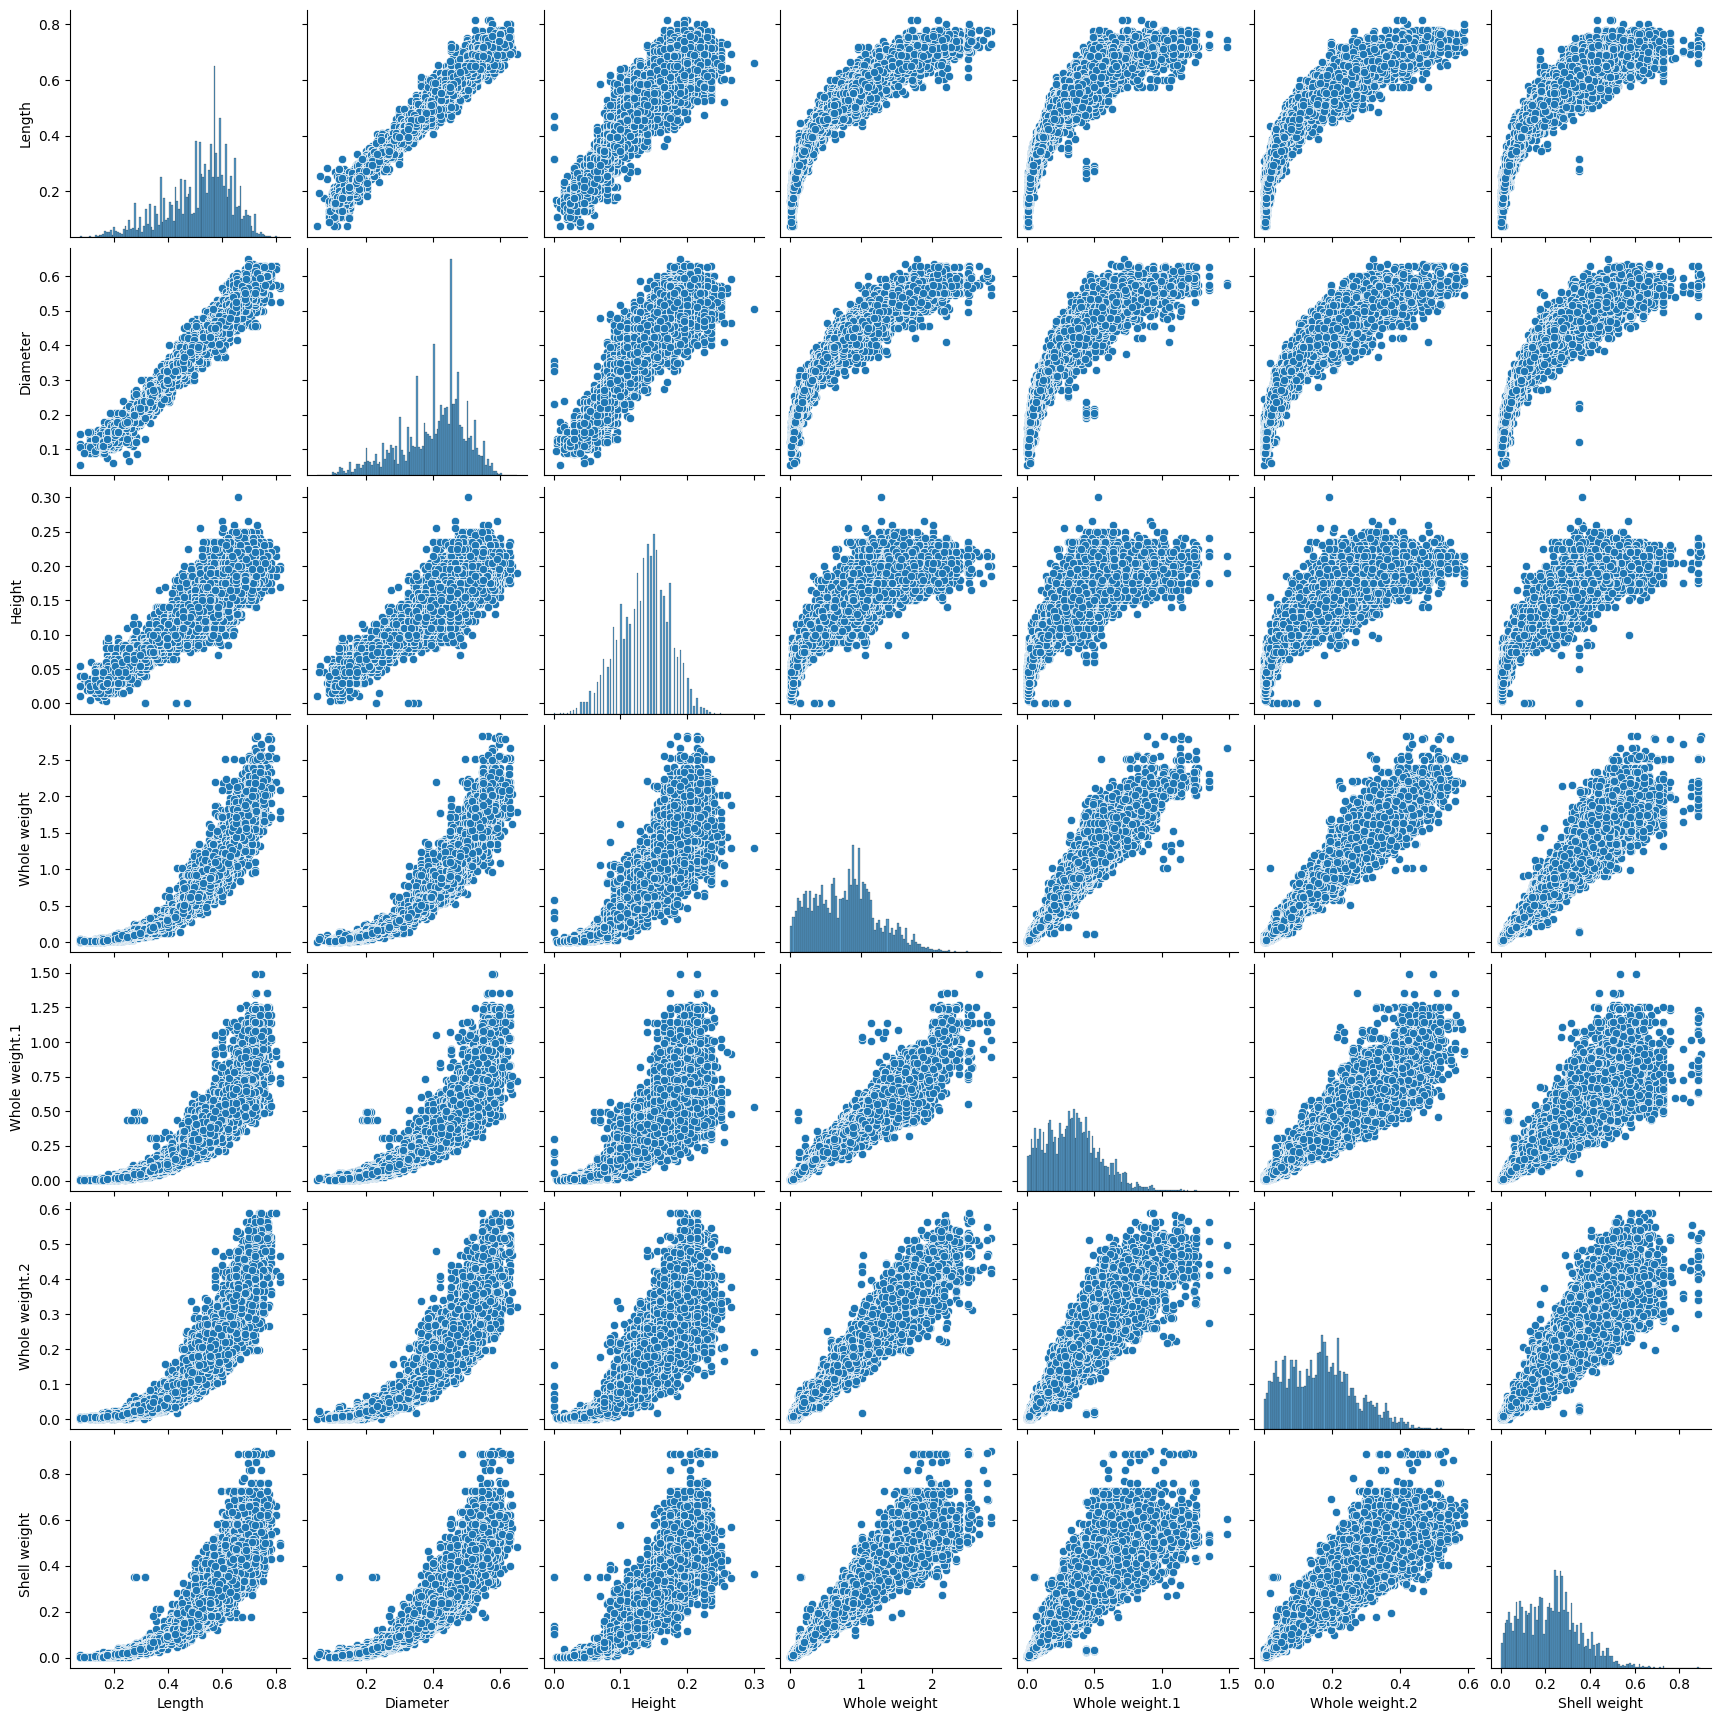

In [46]:
cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight']
sns.pairplot(data = data.loc[:,cols])

In [132]:
evaluate_outliers(X_train, y_train, data,target)

0.1541146603650841

In [10]:
X_train = data
y_train = target

In [25]:
data = data.iloc[:,:-1]

In [144]:
evaluate_dataset(X_train, y_train)

0.15411305685310414

In [114]:
X_train[(X_train['Length'] < 0.35) & (X_train['Whole weight.1'] > 0.38)]

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
id                                                                  
963     I   0.250     0.190   0.060        0.1055           0.435   
6556    I   0.275     0.205   0.070        0.1055           0.495   
6885    I   0.290     0.215   0.070        0.1055           0.495   
7526    I   0.275     0.205   0.070        0.1055           0.495   
7816    I   0.275     0.215   0.065        0.1035           0.495   
12197   I   0.285     0.220   0.060        0.1055           0.435   
15485   I   0.285     0.210   0.060        0.1055           0.435   
16334   I   0.290     0.210   0.060        0.1055           0.495   
34642   I   0.285     0.195   0.060        0.1055           0.435   
46344   I   0.275     0.200   0.065        0.1055           0.435   
50701   I   0.275     0.205   0.070        0.1055           0.495   
61854   I   0.310     0.235   0.060        0.1085           0.435   
72349   I   0.280     0.200   0.080        0.1055           0.495   
74344   I   0.275     0.200   0.060        0.1055           0.495   
76905   I   0.275     0.205   0.070        0.1055           0.495   
77702   F   0.265     0.205   0.070        0.1055           0.435   

       Whole weight.2  Shell weight  Rings    F    I    M  
id                                                         
963            0.0150        0.0390      5  0.0  1.0  0.0  
6556           0.0180        0.0350      6  0.0  1.0  0.0  
6885           0.0180        0.0350      6  0.0  1.0  0.0  
7526           0.0225        0.0300      7  0.0  1.0  0.0  
7816           0.0175        0.0300      5  0.0  1.0  0.0  
12197          0.0150        0.0270      5  0.0  1.0  0.0  
15485          0.0150        0.0300      6  0.0  1.0  0.0  
16334          0.0220        0.0300      6  0.0  1.0  0.0  
34642          0.0150        0.0390      7  0.0  1.0  0.0  
46344          0.0160        0.0350      5  0.0  1.0  0.0  
50701          0.0185        0.0300      9  0.0  1.0  0.0  
61854          0.0150        0.0315      5  0.0  1.0  0.0  
72349          0.0150        0.0300      9  0.0  1.0  0.0  
74344          0.0190        0.0320      7  0.0  1.0  0.0  
76905          0.0190        0.0350      7  0.0  1.0  0.0  
77702          0.0150        0.0350      5  1.0  0.0  0.0

In [17]:
!pip install --upgrade optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: optuna
    Found existing installation: optuna 0.18.1
    Uninstalling optuna-0.18.1:
      Successfully uninstalled optuna-0.18.1


In [8]:
!pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: optuna
    Found existing installation: optuna 3.6.0
    Uninstalling optuna-3.6.0:
      Successfully uninstalled optuna-3.6.0


In [27]:
optuna.__version__

'3.6.0'

In [11]:
import lightgbm as lgb
import optuna

In [10]:
train_data = lgb.Dataset(X_train.loc[:,X_train.columns.values != 'Rings'].select_dtypes(include=['float64','int64']), label = y_train)

In [18]:
from sklearn.metrics import mean_squared_log_error

def mean_squared_log_error_for_lgbm(preds, data :lgb.Dataset):
    return 'mean_squared_log_error', np.sqrt(mean_squared_log_error(preds,data.get_label())), False

def objective(trial):
    params = {
    'num_leaves' : trial.suggest_int('num_leaves', 16, 128),
    'colsample_bytree' : trial.suggest_float('colsample_bytree',0.5,1),
    'subsample' : trial.suggest_float('subsample',0.5,1),
    'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf',1,100),
    'reg_lambda' : trial.suggest_float('reg_lambda', 0.001, 25, log=True)
    }
    params['verbose'] = -1
    params['metric'] = 'None'
    params['stratified'] = False
    params['objective'] = 'regression'
    params['bagging_freq'] = 1
    params['learning_rate'] = 0.3
    params['feature_pre_filter'] = False
    
    res = lgb.cv(params, train_data, num_boost_round = 500, nfold = 5, feval = mean_squared_log_error_for_lgbm, callbacks=[lgb.early_stopping(stopping_rounds=15)])
    #y_pred = model.predict(train_data)
    '''print('start')
    print(res)
    print('end')'''
    
    return res['valid mean_squared_log_error-mean'][-1]

In [41]:
study1 = optuna.create_study(study_name='test_study', direction = 'minimize')

[I 2024-04-09 16:32:33,764] A new study created in memory with name: test_study


In [44]:
study1.optimize(objective, timeout = 5 * 60)

Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:46:39,710] Trial 97 finished with value: 0.15029738365834563 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.8502467108484977, 'subsample': 0.9878754293295725, 'min_child_weight': 88, 'reg_lambda': 0.04091966347195053}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[91]	cv_agg's valid mean_squared_log_error: 0.150297 + 0.000744943
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:46:44,976] Trial 98 finished with value: 0.15008944588570083 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.8680928515225895, 'subsample': 0.9438461117830403, 'min_child_weight': 80, 'reg_lambda': 9.489490801097766}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[70]	cv_agg's valid mean_squared_log_error: 0.150089 + 0.000916003
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:46:50,417] Trial 99 finished with value: 0.15071286273068224 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.837300517327929, 'subsample': 0.5569181236154238, 'min_child_weight': 76, 'reg_lambda': 20.60145724638185}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[58]	cv_agg's valid mean_squared_log_error: 0.150713 + 0.000745259
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:46:54,944] Trial 100 finished with value: 0.15013517739639834 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.8249621338892947, 'subsample': 0.9750392330325433, 'min_child_weight': 84, 'reg_lambda': 7.3425919879978}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[38]	cv_agg's valid mean_squared_log_error: 0.150135 + 0.000928326
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:01,203] Trial 101 finished with value: 0.1500884510145914 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.8860558696260357, 'subsample': 0.9674881362770632, 'min_child_weight': 69, 'reg_lambda': 24.228666314377836}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[84]	cv_agg's valid mean_squared_log_error: 0.150088 + 0.000791317
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:07,624] Trial 102 finished with value: 0.14994940172551424 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.9135338104254529, 'subsample': 0.9553284232610578, 'min_child_weight': 78, 'reg_lambda': 18.9282350636721}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[57]	cv_agg's valid mean_squared_log_error: 0.149949 + 0.000870555
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:13,836] Trial 103 finished with value: 0.1502046934855934 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.9074046719222784, 'subsample': 0.9556883762873525, 'min_child_weight': 77, 'reg_lambda': 12.586742053486466}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[66]	cv_agg's valid mean_squared_log_error: 0.150205 + 0.000860462
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:20,706] Trial 104 finished with value: 0.15000179133356753 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.872717445519539, 'subsample': 0.9149619170688464, 'min_child_weight': 89, 'reg_lambda': 17.244475464506912}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[68]	cv_agg's valid mean_squared_log_error: 0.150002 + 0.000809476
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:26,405] Trial 105 finished with value: 0.15020575725364202 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.9171294231068252, 'subsample': 0.9902005125609937, 'min_child_weight': 86, 'reg_lambda': 18.16762075924158}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[56]	cv_agg's valid mean_squared_log_error: 0.150206 + 0.000754881
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:31,536] Trial 106 finished with value: 0.1502829882487558 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.9693206295750803, 'subsample': 0.9166443627142897, 'min_child_weight': 90, 'reg_lambda': 10.52688814720714}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[48]	cv_agg's valid mean_squared_log_error: 0.150283 + 0.000694077
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:38,577] Trial 107 finished with value: 0.1501989374701591 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.7937345386493886, 'subsample': 0.9481782007609699, 'min_child_weight': 73, 'reg_lambda': 20.05228997255068}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[53]	cv_agg's valid mean_squared_log_error: 0.150199 + 0.00089606
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:45,217] Trial 108 finished with value: 0.15044364167847196 and parameters: {'num_leaves': 92, 'colsample_bytree': 0.8730369412250697, 'subsample': 0.8856831795711319, 'min_child_weight': 81, 'reg_lambda': 16.964801132621155}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[39]	cv_agg's valid mean_squared_log_error: 0.150444 + 0.000606319
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:51,214] Trial 109 finished with value: 0.15028162550905788 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.8593884416719161, 'subsample': 0.9250534120344399, 'min_child_weight': 68, 'reg_lambda': 6.315987505310539}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[68]	cv_agg's valid mean_squared_log_error: 0.150282 + 0.000682609
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:47:57,319] Trial 110 finished with value: 0.1500567822025916 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.929273712615611, 'subsample': 0.9636035349713736, 'min_child_weight': 83, 'reg_lambda': 12.296629848156131}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[61]	cv_agg's valid mean_squared_log_error: 0.150057 + 0.00084615
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:03,600] Trial 111 finished with value: 0.15000793854423042 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.8513464958628286, 'subsample': 0.9361163471732932, 'min_child_weight': 98, 'reg_lambda': 15.240905818276632}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[74]	cv_agg's valid mean_squared_log_error: 0.150008 + 0.000895867
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:11,588] Trial 112 finished with value: 0.15002517780694805 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.8346188353622181, 'subsample': 0.9402110635079387, 'min_child_weight': 93, 'reg_lambda': 16.05478435156037}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[88]	cv_agg's valid mean_squared_log_error: 0.150025 + 0.000821091
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:16,643] Trial 113 finished with value: 0.15025835959521402 and parameters: {'num_leaves': 66, 'colsample_bytree': 0.8503455468919879, 'subsample': 0.938409156228912, 'min_child_weight': 99, 'reg_lambda': 16.125647846081257}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[38]	cv_agg's valid mean_squared_log_error: 0.150258 + 0.000688305
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:21,797] Trial 114 finished with value: 0.15014497296333368 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.8386908686866397, 'subsample': 0.9055237334040365, 'min_child_weight': 95, 'reg_lambda': 8.972371889449715}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[61]	cv_agg's valid mean_squared_log_error: 0.150145 + 0.00088623
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:28,870] Trial 115 finished with value: 0.15007832271958763 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.8285868250114746, 'subsample': 0.9501018123952184, 'min_child_weight': 97, 'reg_lambda': 21.893452443402285}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[113]	cv_agg's valid mean_squared_log_error: 0.150078 + 0.000775031
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:34,996] Trial 116 finished with value: 0.14997868941956605 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.8960369146149945, 'subsample': 0.9305460682083718, 'min_child_weight': 92, 'reg_lambda': 15.237874123733569}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[87]	cv_agg's valid mean_squared_log_error: 0.149979 + 0.000657202
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:41,389] Trial 117 finished with value: 0.15007875993391395 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.8973437772519995, 'subsample': 0.9169906483010676, 'min_child_weight': 90, 'reg_lambda': 20.57069666343844}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[74]	cv_agg's valid mean_squared_log_error: 0.150079 + 0.000727676
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:49,106] Trial 118 finished with value: 0.1501827932742486 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.876165621975322, 'subsample': 0.9307653642408579, 'min_child_weight': 99, 'reg_lambda': 13.358826843566533}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[132]	cv_agg's valid mean_squared_log_error: 0.150183 + 0.000844666
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:48:55,707] Trial 119 finished with value: 0.1502376305095599 and parameters: {'num_leaves': 20, 'colsample_bytree': 0.8921980663177883, 'subsample': 0.9771169040697162, 'min_child_weight': 65, 'reg_lambda': 10.159041248482085}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[129]	cv_agg's valid mean_squared_log_error: 0.150238 + 0.000816084
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:02,177] Trial 120 finished with value: 0.15045902712433917 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.9547752577775674, 'subsample': 0.9571892788800069, 'min_child_weight': 30, 'reg_lambda': 7.978542152991832}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[81]	cv_agg's valid mean_squared_log_error: 0.150459 + 0.000847181
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:07,725] Trial 121 finished with value: 0.1500646314591394 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.8636929176944033, 'subsample': 0.9389994118500481, 'min_child_weight': 92, 'reg_lambda': 15.988304101031652}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[69]	cv_agg's valid mean_squared_log_error: 0.150065 + 0.00080512
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:14,346] Trial 122 finished with value: 0.1501393674470355 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.8162007185404587, 'subsample': 0.9434597192210701, 'min_child_weight': 92, 'reg_lambda': 17.567894736123108}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[72]	cv_agg's valid mean_squared_log_error: 0.150139 + 0.000839142
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:19,922] Trial 123 finished with value: 0.1502714557428524 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.9093576381129019, 'subsample': 0.9246061238250316, 'min_child_weight': 95, 'reg_lambda': 0.010957244508720083}. Best is trial 28 with value: 0.14992299824019867.


Early stopping, best iteration is:
[61]	cv_agg's valid mean_squared_log_error: 0.150271 + 0.000776841
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:26,070] Trial 124 finished with value: 0.14990308452927992 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.8019645435767799, 'subsample': 0.964732967247352, 'min_child_weight': 86, 'reg_lambda': 24.427450456301546}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[93]	cv_agg's valid mean_squared_log_error: 0.149903 + 0.000797509
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:33,379] Trial 125 finished with value: 0.14997556496928507 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.7700469031182828, 'subsample': 0.9689239561108565, 'min_child_weight': 86, 'reg_lambda': 24.558515400201653}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[111]	cv_agg's valid mean_squared_log_error: 0.149976 + 0.00090292
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:40,929] Trial 126 finished with value: 0.15003417332209754 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.7583904944703245, 'subsample': 0.9938180571757607, 'min_child_weight': 87, 'reg_lambda': 13.364577046521052}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[117]	cv_agg's valid mean_squared_log_error: 0.150034 + 0.000709428
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:47,504] Trial 127 finished with value: 0.15016633840014362 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.8021125437205809, 'subsample': 0.9679341873811232, 'min_child_weight': 85, 'reg_lambda': 19.298880356180188}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[80]	cv_agg's valid mean_squared_log_error: 0.150166 + 0.00089608
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:49:53,212] Trial 128 finished with value: 0.15008513815866287 and parameters: {'num_leaves': 36, 'colsample_bytree': 0.7720715462189232, 'subsample': 0.9760654449843491, 'min_child_weight': 89, 'reg_lambda': 11.446097674864033}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[74]	cv_agg's valid mean_squared_log_error: 0.150085 + 0.000830228
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:00,203] Trial 129 finished with value: 0.15007280297648137 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.7881896056727913, 'subsample': 0.9847602991819764, 'min_child_weight': 80, 'reg_lambda': 24.86910835905413}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[88]	cv_agg's valid mean_squared_log_error: 0.150073 + 0.000798408
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:05,201] Trial 130 finished with value: 0.15030308250955962 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.7664929818073474, 'subsample': 0.954938688045864, 'min_child_weight': 83, 'reg_lambda': 0.5668758160428923}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[65]	cv_agg's valid mean_squared_log_error: 0.150303 + 0.000995716
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:12,255] Trial 131 finished with value: 0.1501211903480748 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.8091453575915479, 'subsample': 0.9626452480987859, 'min_child_weight': 86, 'reg_lambda': 24.99612160732403}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[119]	cv_agg's valid mean_squared_log_error: 0.150121 + 0.000854057
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:20,918] Trial 132 finished with value: 0.15004998460528962 and parameters: {'num_leaves': 23, 'colsample_bytree': 0.8488365792418076, 'subsample': 0.99870086648955, 'min_child_weight': 75, 'reg_lambda': 20.84376965649566}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[138]	cv_agg's valid mean_squared_log_error: 0.15005 + 0.000722089
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:25,913] Trial 133 finished with value: 0.15028399314493623 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.7759797060090817, 'subsample': 0.9313727915307279, 'min_child_weight': 71, 'reg_lambda': 0.10305524723256704}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[70]	cv_agg's valid mean_squared_log_error: 0.150284 + 0.000840572
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:32,781] Trial 134 finished with value: 0.1500580294529316 and parameters: {'num_leaves': 28, 'colsample_bytree': 0.8232290505703694, 'subsample': 0.9706285150874899, 'min_child_weight': 78, 'reg_lambda': 14.442999305265095}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[109]	cv_agg's valid mean_squared_log_error: 0.150058 + 0.000790454
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:39,115] Trial 135 finished with value: 0.1499980758509553 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.7957198974666282, 'subsample': 0.9502719519230554, 'min_child_weight': 88, 'reg_lambda': 19.180697355943252}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[65]	cv_agg's valid mean_squared_log_error: 0.149998 + 0.000686252
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:44,668] Trial 136 finished with value: 0.15001321497396192 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.7456201613468116, 'subsample': 0.95083724205121, 'min_child_weight': 97, 'reg_lambda': 17.74661346385554}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[55]	cv_agg's valid mean_squared_log_error: 0.150013 + 0.000816801
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:50,715] Trial 137 finished with value: 0.15013933161666623 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.7930801728236281, 'subsample': 0.9113113895723458, 'min_child_weight': 89, 'reg_lambda': 11.066237394850715}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[52]	cv_agg's valid mean_squared_log_error: 0.150139 + 0.000907054
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:50:55,989] Trial 138 finished with value: 0.15015028269510583 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.8013622245268743, 'subsample': 0.9828531847036313, 'min_child_weight': 85, 'reg_lambda': 14.65729086287285}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[61]	cv_agg's valid mean_squared_log_error: 0.15015 + 0.000916431
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:01,419] Trial 139 finished with value: 0.15006287865757023 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.7801005269901138, 'subsample': 0.9615467505983049, 'min_child_weight': 91, 'reg_lambda': 9.368235966303407}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[58]	cv_agg's valid mean_squared_log_error: 0.150063 + 0.000813589
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:06,533] Trial 140 finished with value: 0.15040212436392916 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.7528651551199677, 'subsample': 0.7175706285554063, 'min_child_weight': 82, 'reg_lambda': 18.51699312182352}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[50]	cv_agg's valid mean_squared_log_error: 0.150402 + 0.000820703
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:13,547] Trial 141 finished with value: 0.15008442467013186 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.7449819600256211, 'subsample': 0.9511485974453218, 'min_child_weight': 98, 'reg_lambda': 19.795936443571353}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[72]	cv_agg's valid mean_squared_log_error: 0.150084 + 0.000659129
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:21,183] Trial 142 finished with value: 0.15001382950725678 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.7226073613714794, 'subsample': 0.9507404506513689, 'min_child_weight': 94, 'reg_lambda': 16.641630517090295}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[70]	cv_agg's valid mean_squared_log_error: 0.150014 + 0.000843361
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:27,999] Trial 143 finished with value: 0.15004418725033428 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.7335484359371519, 'subsample': 0.9469153997210144, 'min_child_weight': 97, 'reg_lambda': 12.425305238179357}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[74]	cv_agg's valid mean_squared_log_error: 0.150044 + 0.000742954
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:33,873] Trial 144 finished with value: 0.15000437360582905 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.7888866835358174, 'subsample': 0.9712101312121363, 'min_child_weight': 94, 'reg_lambda': 20.93363741529883}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[56]	cv_agg's valid mean_squared_log_error: 0.150004 + 0.000765188
Training until validation scores don't improve for 15 rounds


[I 2024-04-09 16:51:39,866] Trial 145 finished with value: 0.15005202677618898 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.7662732808946308, 'subsample': 0.9707311812381575, 'min_child_weight': 93, 'reg_lambda': 24.941057299838373}. Best is trial 124 with value: 0.14990308452927992.


Early stopping, best iteration is:
[55]	cv_agg's valid mean_squared_log_error: 0.150052 + 0.000847006


In [45]:
study1.best_value, study1.best_params

(0.14990308452927992,
 {'num_leaves': 32,
  'colsample_bytree': 0.8019645435767799,
  'subsample': 0.964732967247352,
  'min_child_weight': 86,
  'reg_lambda': 24.427450456301546})

(0.1490983814966363,
 {'num_leaves': 25,
  'colsample_bytree': 0.5275775511251478,
  'subsample': 0.8005890318000105,
  'min_child_weight': 84.43501410020603,
  'reg_lambda': 22.778143121537493})

For improved objective with learning_rate = 0.3
(0.14990308452927992,
 {'num_leaves': 32,
  'colsample_bytree': 0.8019645435767799,
  'subsample': 0.964732967247352,
  'min_child_weight': 86,
  'reg_lambda': 24.427450456301546})

In [13]:
params = {'num_leaves': 32,
  'colsample_bytree': 0.8019645435767799,
  'subsample': 0.964732967247352,
  'min_data_in_leaf': 86,
  'reg_lambda': 24.427450456301546}

params['verbose'] = -1
params['metric'] = 'None'
params['stratified'] = False
params['objective'] = 'regression'
params['bagging_freq'] = 1
params['learning_rate'] = 0.01
params['feature_pre_filter'] = False

lgb.cv(params, train_data, num_boost_round = 10000, nfold = 5, feval = mean_squared_log_error_for_lgbm, callbacks=[lgb.early_stopping(stopping_rounds=30)])


NameError: name 'train_data' is not defined

Early stopping, best iteration is:
[5364]	cv_agg's valid mean_squared_log_error: 0.148828 + 0.000683052

Improved: Early stopping, best iteration is:
[3880]	cv_agg's valid mean_squared_log_error: 0.148904 + 0.000700043

In [63]:
train_data = lgb.Dataset(data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64']), label = target)
eval_data = lgb.Dataset(X_train.loc[:,X_train.columns.values != 'Rings'].select_dtypes(include=['float64','int64']), label = y_train)

In [64]:
evals = {}
model = lgb.train(params, train_data, num_boost_round = 3880, valid_sets = [eval_data], feval = mean_squared_log_error_for_lgbm, callbacks = [lgb.early_stopping(stopping_rounds=30),lgb.record_evaluation(evals)])

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[3880]	valid_0's mean_squared_log_error: 0.140936


In [67]:
#evals['training']['mean_squared_log_error'][-1]
evals['valid_0']['mean_squared_log_error'][-1]

0.14093601440634174

old val: 0.1414934339923785
new_val: 0.14094159981641435


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

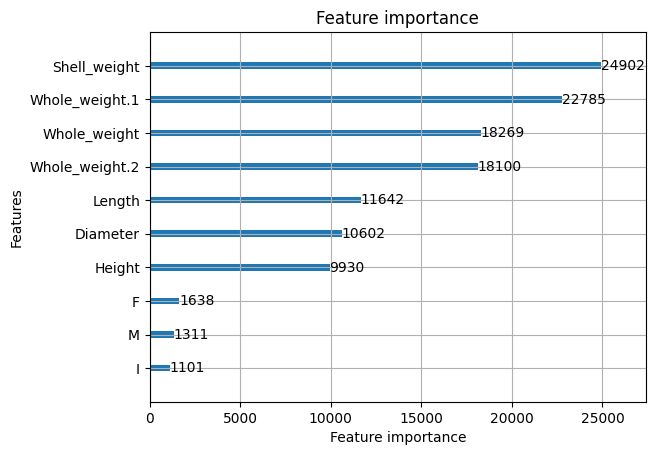

In [51]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='mean_squared_log_error'>

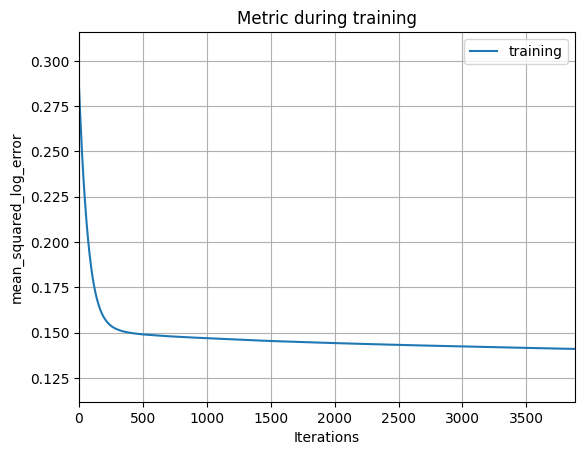

In [52]:
lgb.plot_metric(evals)

In [14]:
pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from optuna_integration.lightgbm import LightGBMTunerCV

In [28]:
parameters = {
    'metric': 'None',
    'verbose': -1,
    'objective': 'regression',
    'stratified': False
}
tuner = LightGBMTunerCV(parameters, train_data, nfold = 5, callbacks = [lgb.early_stopping(stopping_rounds = 30)], feval = mean_squared_log_error_for_lgbm)

[I 2024-04-09 14:41:00,922] A new study created in memory with name: no-name-b102a52a-aae7-4aca-972b-37ca354e8506


In [12]:
def eval_dataset(data, target):
    data_train = lgb.Dataset(data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64']), label = target)
    params = {
        'num_leaves': 32,
        'colsample_bytree': 0.8019645435767799,
        'subsample': 0.964732967247352,
        'min_data_in_leaf': 86,
        'reg_lambda': 24.427450456301546}

    params['verbose'] = -1
    params['metric'] = 'None'
    params['stratified'] = False
    params['objective'] = 'regression'
    params['bagging_freq'] = 1
    params['learning_rate'] = 0.01
    params['feature_pre_filter'] = False

    return lgb.cv(params, data_train, num_boost_round = 10000, nfold = 5, feval = mean_squared_log_error_for_lgbm, callbacks=[lgb.early_stopping(stopping_rounds=30)])
    
    

In [10]:
data['f1'] = np.round(np.sqrt(data['Length'] * data['Height']),2)

In [19]:
data['Whole weight'] = np.round(np.sqrt(data['Whole weight']),2)

In [30]:
data = data.iloc[:,:-1]

In [20]:
eval_dataset(data, target)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3433]	cv_agg's valid mean_squared_log_error: 0.149004 + 0.000608542


{'valid mean_squared_log_error-mean': [0.28671889544819473,
  0.28490775940651014,
  0.28324804170024104,
  0.2814768587032256,
  0.2797295270210116,
  0.2781456788839588,
  0.276436128700314,
  0.27475354368314814,
  0.2732253419685506,
  0.27164754336280694,
  0.27015584253124836,
  0.2686310967067211,
  0.2672765719723616,
  0.2656940824002608,
  0.26413593063186225,
  0.2625947001858785,
  0.26107473884452304,
  0.2595759771868878,
  0.25809781872380516,
  0.25663923247916925,
  0.2551942493180562,
  0.25389008697204607,
  0.252477187877479,
  0.25108686498809785,
  0.24976854914184207,
  0.2484648019623858,
  0.24711758364817576,
  0.24579048295644138,
  0.24454133747582824,
  0.243337771812744,
  0.24205536029175773,
  0.2408827540286944,
  0.23962913241508782,
  0.23845733290384144,
  0.2372346859164794,
  0.23602890571553842,
  0.23483761641194403,
  0.2336618545380346,
  0.23265787538659755,
  0.2315103017999892,
  0.2304602649670855,
  0.22938761283463868,
  0.228328643361460

In [12]:
from sklearn.cluster import KMeans

for i in range(2,13):
    km = KMeans(n_clusters = i, random_state = 0)
    data['cluster'] = km.fit_predict(data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64'])).astype('int64')
    res = eval_dataset(data, target)
    print(i, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3619]	cv_agg's valid mean_squared_log_error: 0.148929 + 0.000544046
2 0.14892877734637938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3433]	cv_agg's valid mean_squared_log_error: 0.148944 + 0.000538058
3 0.1489435943726219
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.14893 + 0.000567947
4 0.14892966379973366
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148947 + 0.00053958
5 0.14894705822182525
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3439]	cv_agg's valid mean_squared_log_error: 0.148919 + 0.000551233
6 0.14891913592122533
Training until validation scores don't improve for 30 rounds
Early s

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3619]	cv_agg's valid mean_squared_log_error: 0.148929 + 0.000544046
2 0.14892877734637938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3433]	cv_agg's valid mean_squared_log_error: 0.148944 + 0.000538058
3 0.1489435943726219
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.14893 + 0.000567947
4 0.14892966379973366
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148947 + 0.00053958
5 0.14894705822182525
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3439]	cv_agg's valid mean_squared_log_error: 0.148919 + 0.000551233
6 0.14891913592122533
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148934 + 0.000557743
7 0.14893407640320017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3433]	cv_agg's valid mean_squared_log_error: 0.14895 + 0.000539937
8 0.14894971419492634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3939]	cv_agg's valid mean_squared_log_error: 0.148889 + 0.000541405
9 0.1488892007212409
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148931 + 0.000549778
10 0.14893090509437495
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3619]	cv_agg's valid mean_squared_log_error: 0.14892 + 0.000574565
11 0.1489203217354443
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3762]	cv_agg's valid mean_squared_log_error: 0.148922 + 0.000565473
12 0.14892182486056185

In [11]:
data.columns.values

array(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings', 'F',
       'I', 'M'], dtype=object)

In [12]:
from sklearn.cluster import KMeans

for i in range(2,13):
    km = KMeans(n_clusters = i, random_state = 0)
    data['cluster'] = km.fit_predict(data.loc[:,['Length', 'Diameter', 'Height']].select_dtypes(include=['float64','int64'])).astype('int64')
    res = eval_dataset(data, target)
    print(i, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148936 + 0.000541581
2 0.14893626137416952
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148923 + 0.000536603
3 0.148922688073228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148937 + 0.000557919
4 0.1489365963216413
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3750]	cv_agg's valid mean_squared_log_error: 0.148895 + 0.000537332
5 0.14889545006265942
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3162]	cv_agg's valid mean_squared_log_error: 0.148951 + 0.000549153
6 0.14895114630390735
Training until validation scores don't improve for 30 rounds
Early s

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148936 + 0.000541581
2 0.14893626137416952
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148923 + 0.000536603
3 0.148922688073228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148937 + 0.000557919
4 0.1489365963216413
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3750]	cv_agg's valid mean_squared_log_error: 0.148895 + 0.000537332
5 0.14889545006265942
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3162]	cv_agg's valid mean_squared_log_error: 0.148951 + 0.000549153
6 0.14895114630390735
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148952 + 0.00055504
7 0.14895154337498462
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3735]	cv_agg's valid mean_squared_log_error: 0.148917 + 0.000585836
8 0.14891722327275475
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148914 + 0.00056174
9 0.14891417146427155
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3431]	cv_agg's valid mean_squared_log_error: 0.148912 + 0.000545161
10 0.14891211200116894
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148942 + 0.000548406
11 0.14894172699663202
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3941]	cv_agg's valid mean_squared_log_error: 0.148895 + 0.000569346
12 0.1488945385287812

In [13]:
for i in range(15,50,15):
    km = KMeans(n_clusters = i, random_state = 0)
    data['cluster'] = km.fit_predict(data.loc[:,['Length', 'Diameter', 'Height']].select_dtypes(include=['float64','int64'])).astype('int64')
    res = eval_dataset(data, target)
    print(i, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148944 + 0.000562909
15 0.14894448595160564
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3799]	cv_agg's valid mean_squared_log_error: 0.148978 + 0.000579253
30 0.14897843981352404
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3423]	cv_agg's valid mean_squared_log_error: 0.149034 + 0.000568173
45 0.14903380492728674


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148944 + 0.000562909
15 0.14894448595160564
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3799]	cv_agg's valid mean_squared_log_error: 0.148978 + 0.000579253
30 0.14897843981352404
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3423]	cv_agg's valid mean_squared_log_error: 0.149034 + 0.000568173
45 0.14903380492728674

In [14]:
from sklearn.cluster import KMeans

for i in range(2,6):
    km = KMeans(n_clusters = i, random_state = 0)
    data['cluster'] = km.fit_predict(data.loc[:,['Whole weight','Whole weight.1', 'Whole weight.2', 'Shell weight']].select_dtypes(include=['float64','int64'])).astype('int64')
    res = eval_dataset(data, target)
    print(i, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3434]	cv_agg's valid mean_squared_log_error: 0.148933 + 0.000545143
2 0.14893296524100785
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148941 + 0.000554421
3 0.14894116463575086
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148936 + 0.000541662
4 0.14893590813584914
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3436]	cv_agg's valid mean_squared_log_error: 0.148931 + 0.000550474
5 0.1489314550093494


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3434]	cv_agg's valid mean_squared_log_error: 0.148933 + 0.000545143
2 0.14893296524100785
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3430]	cv_agg's valid mean_squared_log_error: 0.148941 + 0.000554421
3 0.14894116463575086
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3432]	cv_agg's valid mean_squared_log_error: 0.148936 + 0.000541662
4 0.14893590813584914
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3436]	cv_agg's valid mean_squared_log_error: 0.148931 + 0.000550474
5 0.1489314550093494

In [15]:
from sklearn.cluster import KMeans

for i in range(10,35,10):
    km = KMeans(n_clusters = i, random_state = 0)
    data['cluster'] = km.fit_predict(data.loc[:,['Whole weight','Whole weight.1', 'Whole weight.2', 'Shell weight']].select_dtypes(include=['float64','int64'])).astype('int64')
    res = eval_dataset(data, target)
    print(i, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3749]	cv_agg's valid mean_squared_log_error: 0.148898 + 0.000559811
10 0.14889788649025243
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3872]	cv_agg's valid mean_squared_log_error: 0.148915 + 0.000520542
20 0.14891511126706813
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3774]	cv_agg's valid mean_squared_log_error: 0.148989 + 0.000622453
30 0.14898878720186987


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3749]	cv_agg's valid mean_squared_log_error: 0.148898 + 0.000559811
10 0.14889788649025243
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3872]	cv_agg's valid mean_squared_log_error: 0.148915 + 0.000520542
20 0.14891511126706813
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3774]	cv_agg's valid mean_squared_log_error: 0.148989 + 0.000622453
30 0.14898878720186987

In [31]:
res = eval_dataset(data, target)
print(0, res['valid mean_squared_log_error-mean'][-1])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3647]	cv_agg's valid mean_squared_log_error: 0.148884 + 0.000576748
5 0.14888359036114593


clustering doesn't improve score

In [33]:
data.select_dtypes(include=['float64','int64'])

Length  Diameter  Height  Whole weight  Whole weight.1  Whole weight.2  \
id                                                                              
0       0.550     0.430   0.150        0.7715          0.3285          0.1465   
1       0.630     0.490   0.145        1.1300          0.4580          0.2765   
2       0.160     0.110   0.025        0.0210          0.0055          0.0030   
3       0.595     0.475   0.150        0.9145          0.3755          0.2055   
4       0.555     0.425   0.130        0.7820          0.3695          0.1600   
...       ...       ...     ...           ...             ...             ...   
90610   0.335     0.235   0.075        0.1585          0.0685          0.0370   
90611   0.555     0.425   0.150        0.8790          0.3865          0.1815   
90612   0.435     0.330   0.095        0.3215          0.1510          0.0785   
90613   0.345     0.270   0.075        0.2000          0.0980          0.0490   
90614   0.425     0.325   0.100        0.3455          0.1525          0.0785   

       Shell weight  Rings    F    I    M  
id                                         
0            0.2400     11  1.0  0.0  0.0  
1            0.3200     11  1.0  0.0  0.0  
2            0.0050      6  0.0  1.0  0.0  
3            0.2500     10  0.0  0.0  1.0  
4            0.1975      9  0.0  1.0  0.0  
...             ...    ...  ...  ...  ...  
90610        0.0450      6  0.0  0.0  1.0  
90611        0.2400      9  0.0  0.0  1.0  
90612        0.0815      6  0.0  1.0  0.0  
90613        0.0700      6  0.0  1.0  0.0  
90614        0.1050      8  0.0  1.0  0.0  

[90597 rows x 11 columns]

In [13]:
from sklearn.decomposition import PCA

pca = PCA().set_output(transform = 'pandas')
data_pca = pca.fit_transform(data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64']))
#data_pca = np.round(data_pca,3)

'''for i in range(4):
    #print(data_pca.iloc[:,:10-i])
    res = eval_dataset(data_pca.iloc[:,:10-i], target)
    print(i, res['valid mean_squared_log_error-mean'][-1])'''
    

"for i in range(4):\n    #print(data_pca.iloc[:,:10-i])\n    res = eval_dataset(data_pca.iloc[:,:10-i], target)\n    print(i, res['valid mean_squared_log_error-mean'][-1])"

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1409]	cv_agg's valid mean_squared_log_error: 0.152024 + 0.0006095
0 0.15202398330798286
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1409]	cv_agg's valid mean_squared_log_error: 0.152024 + 0.0006095
1 0.15202398330798286
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1409]	cv_agg's valid mean_squared_log_error: 0.152024 + 0.0006095
2 0.15202398330798286
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1347]	cv_agg's valid mean_squared_log_error: 0.152142 + 0.000563724
3 0.15214204396340988

In [15]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.8 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [22]:
from sklearn.base import BaseEstimator

def mean_squared_log_error_for_lgbmRegressor(target, preds):
    return 'mean_squared_log_error', np.sqrt(mean_squared_log_error(preds,target)), False

class MyEstimator(BaseEstimator): 
    def __init__(self):
        params = {
        'n_estimators': 1000,
        'learning_rate': 0.3,
        'num_leaves': 32,
        'colsample_bytree': 0.8019645435767799,
        'subsample': 0.964732967247352,
        'min_data_in_leaf': 86,
        'reg_lambda': 24.427450456301546}

        params['verbose'] = -1
        params['metric'] = 'None'
        params['stratified'] = False
        params['objective'] = 'regression'
        params['bagging_freq'] = 1
        params['learning_rate'] = 0.01
        params['feature_pre_filter'] = False
        
        self.model = LGBMRegressor(**params)

    def fit(self, X, y, **kwargs):
        fit_params = {'eval_set' : [(X,y)],'eval_metric' : mean_squared_log_error_for_lgbmRegressor, 'callbacks' : [lgb.early_stopping(stopping_rounds=30)]}
        self.model.fit(X, y, **fit_params)
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X):
        result = self.model.predict(X)    
        return result
    
    def score(self, X, y):
        return self.model.score(X,y)

In [23]:
import sklearn
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor


#sklearn.set_config(enable_metadata_routing=True)


model = MyEstimator()
#model.set_fit_request(eval_metric = True, callbacks= True)

selector = RFECV(model)
selector.fit(pd.concat([data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64']),data_pca], axis = 1), target)

RFECV(estimator=MyEstimator())

In [24]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 5, 6, 7, 3, 4, 1, 1, 1, 1, 1, 1, 1, 2])

array([1, 1, 1, 1, 1, 1, 1, 5, 6, 7, 3, 4, 1, 1, 1, 1, 1, 1, 1, 2])


In [16]:
idx = np.array([1, 1, 1, 1, 1, 1, 1, 5, 6, 7, 3, 4, 1, 1, 1, 1, 1, 1, 1, 2])
idx = np.argwhere(idx == 1).ravel()

data_concat = pd.concat([data.loc[:,data.columns.values != 'Rings'].select_dtypes(include=['float64','int64']),data_pca], axis=1)
data_concat = data_concat.iloc[:,idx]
data_concat

Length  Diameter  Height  Whole weight  Whole weight.1  Whole weight.2  \
id                                                                              
0       0.550     0.430   0.150        0.7715          0.3285          0.1465   
1       0.630     0.490   0.145        1.1300          0.4580          0.2765   
2       0.160     0.110   0.025        0.0210          0.0055          0.0030   
3       0.595     0.475   0.150        0.9145          0.3755          0.2055   
4       0.555     0.425   0.130        0.7820          0.3695          0.1600   
...       ...       ...     ...           ...             ...             ...   
90610   0.335     0.235   0.075        0.1585          0.0685          0.0370   
90611   0.555     0.425   0.150        0.8790          0.3865          0.1815   
90612   0.435     0.330   0.095        0.3215          0.1510          0.0785   
90613   0.345     0.270   0.075        0.2000          0.0980          0.0490   
90614   0.425     0.325   0.100        0.3455          0.1525          0.0785   

       Shell weight      pca2      pca3      pca4      pca5      pca6  \
id                                                                      
0            0.2400 -0.362158 -0.036496 -0.016580  0.014837  0.019143   
1            0.3200 -0.051469 -0.034457  0.002783 -0.024824 -0.026712   
2            0.0050 -0.212379  0.186135  0.101838  0.010831 -0.003757   
3            0.2500 -0.125082 -0.055034 -0.020638 -0.024828 -0.003399   
4            0.1975  0.516685 -0.034744 -0.055534 -0.011711  0.009505   
...             ...       ...       ...       ...       ...       ...   
90610        0.0450 -0.810355  0.067301  0.018591 -0.001477 -0.001166   
90611        0.2400 -0.159963 -0.000622 -0.014848 -0.005377  0.008683   
90612        0.0815  0.105635 -0.029326 -0.035355 -0.013562 -0.006974   
90613        0.0700 -0.011565  0.025490  0.007960  0.011474 -0.008900   
90614        0.1050  0.123328 -0.024186 -0.012958 -0.000443 -0.005088   

           pca7      pca8  
id                         
0      0.006484  0.000831  
1     -0.024141  0.000351  
2     -0.019486 -0.002063  
3     -0.003645 -0.008574  
4     -0.006359  0.001709  
...         ...       ...  
90610 -0.008871  0.013043  
90611  0.005649  0.006921  
90612 -0.008350 -0.000951  
90613 -0.010208 -0.009967  
90614 -0.004116 -0.001706  

[90597 rows x 14 columns]

In [19]:
eval_dataset(data_concat, target)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2783]	cv_agg's valid mean_squared_log_error: 0.149706 + 0.000600393


{'valid mean_squared_log_error-mean': [0.28657207282581887,
  0.28470506016034836,
  0.2829319876634674,
  0.2811114310643225,
  0.2793122766796796,
  0.27753722929998753,
  0.27580752004962655,
  0.274077256316405,
  0.27237006403107067,
  0.2707365349265197,
  0.26908432073130345,
  0.26744039041072987,
  0.26582092654585854,
  0.26421599423866915,
  0.26263975700523234,
  0.2611598214550043,
  0.25969780802762915,
  0.2581717862270346,
  0.25667821818906017,
  0.25519080013737894,
  0.25372343582795825,
  0.2522805709559911,
  0.250860635326979,
  0.24944725576941257,
  0.2480530643576031,
  0.24667507984223355,
  0.24531709789774553,
  0.24397695718676177,
  0.24265029973520486,
  0.24137930415050982,
  0.24008846098782533,
  0.2388146194625409,
  0.23758639067356083,
  0.23634849816623005,
  0.2351255053154048,
  0.2339145388676375,
  0.23271940771229388,
  0.23157327690138946,
  0.23043808881210617,
  0.22929087721760122,
  0.2281559361693498,
  0.2270694502156018,
  0.2259907856

In [25]:
selector.feature_names_in_

array(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'F', 'I', 'M', 'pca0', 'pca1',
       'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9'],
      dtype=object)

In [26]:
selector.cv_results_

SyntaxError: invalid syntax (1933637684.py, line 1)

In [21]:
lgb.__version__

'4.2.0'

In [20]:
sklearn.__version__

NameError: name 'sklearn' is not defined